In [1]:
from dataset import get_datasets


train_dataset, test_dataset = get_datasets()

In [2]:
import pandas as pd
import torch.nn as nn
from torchvision import models

from dataset import PosterDataset


df = pd.read_csv(PosterDataset.csv_file)

resnet = models.resnet50(pretrained=True)
last_layer_classifier = nn.Sequential(
    nn.Linear(resnet.fc.in_features, len(df.columns) - 2), nn.Sigmoid()
)

/home/boris/anaconda3/envs/csfyp-gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/boris/anaconda3/envs/csfyp-gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import wandb

PROJECT_NAME = "STAT4012Project"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: borisleung2013 (csfyp23). Use `wandb login --relogin` to force relogin


True

In [4]:
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader
from torch import optim


from model import pretrainedModel


config = {"batch_size": 32, "loss_fn": nn.BCELoss, "optimizer": optim.Adam, "lr": 1e-5}
model = pretrainedModel(
    resnet,
    last_layer_classifier,
    config["loss_fn"],
    config["optimizer"],
    lr=config["lr"],
)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
validation_dataloader = DataLoader(
    test_dataset, batch_size=config["batch_size"], shuffle=False
)

logger = WandbLogger(name="Resnet50-T", project=PROJECT_NAME, log_model="all")

trainer = L.Trainer(max_epochs=10, logger=logger)
trainer.fit(
    model,
    train_dataloaders=validation_dataloader,
    val_dataloaders=validation_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | features         | Sequential | 23.5 M
1 | class_classifier | Sequential | 38.9 K
2 | loss_fn          | BCELoss    | 0     
------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.188    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/boris/anaconda3/envs/csfyp-gpu/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/boris/anaconda3/envs/csfyp-gpu/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 3431/3431 [1:17:52<00:00,  0.73it/s, v_num=4rv6, train_loss_step=0.0809, val_loss_step=0.0305, val_loss_epoch=0.0613, train_loss_epoch=0.0259]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 3431/3431 [1:17:58<00:00,  0.73it/s, v_num=4rv6, train_loss_step=0.0809, val_loss_step=0.0305, val_loss_epoch=0.0613, train_loss_epoch=0.0259]


## Model Evaluation


In [1]:
# download from wandb
# can ignore this part 
# =====================
# import wandb

# run = wandb.init()
# artifact = run.use_artifact("csfyp23/STAT4012Project/model-h4do4rv6:v9", type="model")
# artifact_dir = artifact.download()

In [6]:
import pandas as pd
from torchvision import models
import torch.nn as nn

from dataset import PosterDataset

df = pd.read_csv(PosterDataset.csv_file)
resnet = models.resnet50()
last_layer_classifier = nn.Sequential(
    nn.Linear(resnet.fc.in_features, len(df.columns) - 2), nn.Sigmoid()
)

In [5]:
import os

from model import pretrainedModel

model_loaded = pretrainedModel.load_from_checkpoint(
    os.path.join("checkpoints", "resnet50-epochs=10.ckpt"),
    pre_trained_model=resnet,
    last_layer_classifier=last_layer_classifier,
    num_labels=len(df.columns) - 2,
)

In [9]:
import lightning as L
import numpy as np
import torch
from torch.utils.data import DataLoader

from dataset import PosterDataset

all_data = PosterDataset()
all_dataloader = DataLoader(all_data, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

trainer = L.Trainer()
predictions = trainer.predict(model_loaded, all_dataloader)
all_prediction = np.concatenate(predictions)
prediction_filename = "resnet50_predictions.npz"
np.savez_compressed(prediction_filename, all_prediction)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [3]:
all_prediction = np.load("resnet50_predictions.npz")["all_prediction"]

In [7]:
from sklearn.metrics import roc_auc_score

from dataset import PosterDataset


# Concatenate all the batches
true_labels = df.iloc[:, 1:-1].to_numpy().astype(np.float32)
pred_probs = all_prediction

# Calculate ROC AUC for each label
roc_auc_scores = {}
for i in range(true_labels.shape[1]):  # Iterate over each label
    roc_auc_scores[f"Label {i}"] = roc_auc_score(true_labels[:, i], pred_probs[:, i])

# Print ROC AUC scores for each label
for label, score in roc_auc_scores.items():
    print(f"{label}: {score:.4f}")

# Calculate the average ROC AUC score across all labels
average_roc_auc = np.mean(list(roc_auc_scores.values()))
print(f"Average ROC AUC: {average_roc_auc:.4f}")

Label 0: 0.8202
Label 1: 0.7650
Label 2: 0.9343
Label 3: 0.7887
Label 4: 0.7431
Label 5: 0.8317
Label 6: 0.7531
Label 7: 0.7832
Label 8: 0.7217
Label 9: 0.7339
Label 10: 0.8453
Label 11: 0.7745
Label 12: 0.7176
Label 13: 0.7742
Label 14: 0.7740
Label 15: 0.7627
Label 16: 0.7905
Label 17: 0.7867
Label 18: 0.9067
Average ROC AUC: 0.7899


In [ ]:
import torchmetrics, torch

torchmetrics.classification.MultilabelAUROC(true_labels.shape[1])(torch.tensor(pred_probs), torch.tensor(true_labels).long())

tensor(0.7899)

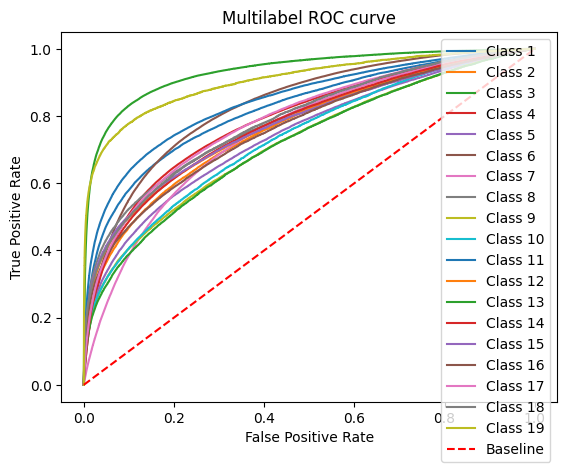

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Assuming `true_labels` and `pred_probs` are your true labels and predicted probabilities
for i in range(true_labels.shape[1]):
    fpr, tpr, _ = roc_curve(true_labels[:, i], pred_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {i+1}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multilabel ROC curve')
plt.legend()
plt.show()